In [ ]:
!pip install -U tensorflow-text==2.6.0
!pip install tensorflow_hub
!pip install --user -U nltk
!pip install contractions

In [1]:
# Install needed libraries
import pandas as pd 
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

import os
import shutil
import string
import contractions

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

import matplotlib.pyplot as plt

# Gensim and LDA
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.parsing.preprocessing import STOPWORDS
import pyLDAvis
import pyLDAvis.gensim_models 

print("Successfully imported all packages")

[nltk_data] Downloading package punkt to /Users/marinmes/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/marinmes/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/marinmes/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/marinmes/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Successfully imported all packages


In [2]:
# Loading the data
data = pd.read_csv('socialmedia-disaster-tweets-DFE 3.csv', error_bad_lines=False)
data = data.drop(columns=["_unit_id", "_golden", "_unit_state", "_trusted_judgments","choose_one:confidence", "choose_one_gold", "_last_judgment_at"])
data["target"] = data.apply(lambda row: 1 if row["choose_one"]== "Relevant" else 0 ,axis =1)
data.shape

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(10876, 7)

In [3]:
# Filtering on the emergent tweets
data_emergencies = data[data.target != 0]
data_emergencies.head()
data_emergencies.shape

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(4673, 7)

In [4]:
# A function for all preprocessing steps

def preprocess_topic_modelling(data_emergencies):
    
    """
    
    This function will execute all the necessary preprocessing steps for
    the topic modelling of our dataset. 
    
    It includes removing emojis, expanding contractions (I'm -> I am), removing punctuation, 
    removing stop words, lemmatization, stemming, removing short words (< 3 characters) and tokenizing.

    Args:
        You must input your data
    
    """
    
    # Remove any strings with numbers
    data_emergencies['concat_data'] = data_emergencies["text"].str.replace(r'\w*\d\w*','')
    data_emergencies['concat_data_2'] = data_emergencies["concat_data"].str.replace(r'\d\S+','')
    
    # Remove words starting with http
    data_emergencies['concat_data_3'] = data_emergencies["concat_data_2"].str.replace(r'http\S+','')
    
    # Expand contractions
    data_emergencies["Tweets with expanded contractions"] = data_emergencies["concat_data_3"].apply(lambda x: ' '.join([contractions.fix(word) for word in x.split()]))
    data_emergencies.head() 
    
    # Remove punctuation
    data_emergencies["Tweets without punctuation"] = data_emergencies["Tweets with expanded contractions"].apply(lambda x: ''.join([i for i in x if i not in string.punctuation]))
    data_emergencies.head()
    
    # Remove short words
    data_emergencies["Short Words Removed"] = data_emergencies["Tweets without punctuation"].apply(lambda x: ' '.join([w.strip() for w in x.split() if len(w.strip()) > 2]))
    data_emergencies.head() 
    
    # Remove capital letters
    data_emergencies["Capital letters removed"] = data_emergencies["Short Words Removed"].str.lower()
    data_emergencies.head() 
    
    # Tokenization
    tokenized_tweets = []
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')

    for row in data_emergencies['Capital letters removed'].values:
        final_tokenized_tweet = []
        tweets = nltk.sent_tokenize(row)
        for tweet in tweets:
            tokens = tokenizer.tokenize(tweet)
            final_tokenized_tweet.extend(tokens)
        tokenized_tweets.append(final_tokenized_tweet)
        
    data_emergencies['Tokenized tweets'] = tokenized_tweets 

    data_emergencies.head()
    
    # Lemmatization
    lemmatized_tweets = []
    lemmatizer = WordNetLemmatizer()

    for tweet in data_emergencies["Tokenized tweets"]:
            lem_list = []
            for i in range(len(tweet)):
                    lem = lemmatizer.lemmatize(tweet[i])
                    lem_list.append(lem)
            lemmatized_tweets.append(lem_list)
    data_emergencies["Lemmatized tweets"] = lemmatized_tweets

    data_emergencies.head()
    
    # Removing stopwords
    stop_words = set(stopwords.words('english'))
    stopwords_removed_tweets = []
    for tweet in lemmatized_tweets:
            stop_m = [i for i in tweet if str(i).lower() not in stop_words]
            stopwords_removed_tweets.append(stop_m)
    data_emergencies['Stopwords removed'] = stopwords_removed_tweets

    data_emergencies.head()
    
    return data_emergencies

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
# Put our emergencies dataset in the function and preprocess it
data_preprocessed = preprocess_topic_modelling(data_emergencies)
data_preprocessed.head()

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-4-55f3a995d8d5>:17: FutureWarning: The default value of regex will change from True to False in a future version.
  data_emergencies['concat_data'] = data_emergencies["text"].str.replace(r'\w*\d\w*','')
<ipython-input-4-55f3a995d8d5>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_emergencies['concat_data'] = data_emergencies["text"].str.replace(r'\w*\d\w*','')
<ipython-inp

,choose_one,keyword,location,text,tweetid,userid,target,concat_data,concat_data_2,concat_data_3,Tweets with expanded contractions,Tweets without punctuation,Short Words Removed,Capital letters removed,Tokenized tweets,Lemmatized tweets,Stopwords removed
0,Relevant,NaN,NaN,Just happened a terrible car crash,1.0,NaN,1,Just happened a terrible car crash,Just happened a terrible car crash,Just happened a terrible car crash,Just happened a terrible car crash,Just happened a terrible car crash,Just happened terrible car crash,just happened terrible car crash,"[just, happened, terrible, car, crash]","[just, happened, terrible, car, crash]","[happened, terrible, car, crash]"
1,Relevant,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,13.0,NaN,1,Our Deeds are the Reason of this #earthquake M...,Our Deeds are the Reason of this #earthquake M...,Our Deeds are the Reason of this #earthquake M...,Our Deeds are the Reason of this #earthquake M...,Our Deeds are the Reason of this earthquake Ma...,Our Deeds are the Reason this earthquake May A...,our deeds are the reason this earthquake may a...,"[our, deeds, are, the, reason, this, earthquak...","[our, deed, are, the, reason, this, earthquake...","[deed, reason, earthquake, may, allah, forgive]"
2,Relevant,NaN,NaN,"Heard about #earthquake is different cities, s...",14.0,NaN,1,"Heard about #earthquake is different cities, s...","Heard about #earthquake is different cities, s...","Heard about #earthquake is different cities, s...","Heard about #earthquake is different cities, s...",Heard about earthquake is different cities sta...,Heard about earthquake different cities stay s...,heard about earthquake different cities stay s...,"[heard, about, earthquake, different, cities, ...","[heard, about, earthquake, different, city, st...","[heard, earthquake, different, city, stay, saf..."
3,Relevant,NaN,NaN,"there is a forest fire at spot pond, geese are...",15.0,NaN,1,"there is a forest fire at spot pond, geese are...","there is a forest fire at spot pond, geese are...","there is a forest fire at spot pond, geese are...","there is a forest fire at spot pond, geese are...",there is a forest fire at spot pond geese are ...,there forest fire spot pond geese are fleeing ...,there forest fire spot pond geese are fleeing ...,"[there, forest, fire, spot, pond, geese, are, ...","[there, forest, fire, spot, pond, goose, are, ...","[forest, fire, spot, pond, goose, fleeing, acr..."
4,Relevant,NaN,NaN,Forest fire near La Ronge Sask. Canada,16.0,NaN,1,Forest fire near La Ronge Sask. Canada,Forest fire near La Ronge Sask. Canada,Forest fire near La Ronge Sask. Canada,Forest fire near La Ronge Sask. Canada,Forest fire near La Ronge Sask Canada,Forest fire near Ronge Sask Canada,forest fire near ronge sask canada,"[forest, fire, near, ronge, sask, canada]","[forest, fire, near, ronge, sask, canada]","[forest, fire, near, ronge, sask, canada]"


### LDA

LDA requires input in the form of a document-term matrix. For this paper, the document-term matrix will have all tweets as rows, and all words as columns. The values within this matrix represent the count of a word within a specific tweet. To generate this matrix, first a dictionary which assigns a unique ID to each word created. Since in the end each topic will consist of a set of words where the order does not matter, we use the bag of words format while generating the document-term matrix. 

In [32]:
# We make a dictionary which assigns an index to each unique word
dictionary = corpora.Dictionary(data_preprocessed["Stopwords removed"])
print("Number of unique words: ", len(dictionary))

Number of unique words:  9655


/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [28]:
# Now we convert the list of our tweets into a document-term matrix using our previously defined dictionary
# We use the bag of words as the order does not matter
document_term_matrix = [dictionary.doc2bow(i) for i in data_preprocessed["Stopwords removed"]]
document_term_matrix[:3]

# The output of the basically says: the 0th word in the dictionary is repeated once, the first word in the dictionary is repeated once, etc.
# It basically shows us the index of the word and its frequency.

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[[(0, 1), (1, 1), (2, 1), (3, 1)],
 [(4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1)],
 [(6, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1)]]

With the input ready, several hyperparameters need to be specified in the LDA model. One of these is the number of topics that the dataset should be divided into. Literature shows that the best way to determine this is by evaluating the model’s coherence score for varying number of topics, since it leads to the better human interpretability (Röder, Both & Hinneburg, 2015). The coherence score is based on the degree of semantic similarity between high scoring words within a topic, and this way the coherence between the different topics inferred by the LDA model is evaluated (Kapadia, 2019). After plotting the coherence score for different values for the number of topics, we find that the best number of topics is 8.

In [33]:
# A function which computes the coherence score for various number of topics.
LDA = gensim.models.ldamodel.LdaModel
def compute_coherence_values(dictionary, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model=LDA(corpus=document_term_matrix, id2word=dictionary, num_topics=num_topics, passes=40,iterations=200, chunksize = 10000)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


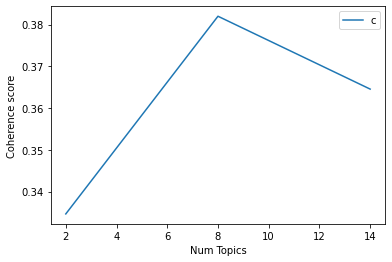

In [31]:
# In this cell we plot the coherence score of the model to find the optimal number of topics
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=document_term_matrix, texts=data_preprocessed["Stopwords removed"], start=2, limit=20, step=6)

# Show graph
import matplotlib.pyplot as plt
limit=20; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [50]:
# Set up the model with the correct number of topics
model_2=LDA(corpus=document_term_matrix, id2word=dictionary, num_topics=8, passes=40,iterations=200, chunksize = 10000)

# Extracting the topics from the corpus
print(model_2.print_topics(num_topics=8, num_words=10))

# num_topics: how many topics want to extract 
# num_words: the number of words that want per topic

# This returns the following six topics (indexed from 0,1,2,3,4,5) with the five words in each of the topics along with their respective weights.

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0, '0.010*"get" + 0.009*"latest" + 0.009*"california" + 0.009*"wildfire" + 0.008*"amp" + 0.008*"home" + 0.008*"news" + 0.008*"watch" + 0.007*"nuclear" + 0.007*"weather"'), (1, '0.020*"hiroshima" + 0.011*"fire" + 0.009*"bombing" + 0.008*"mass" + 0.007*"atomic" + 0.007*"japan" + 0.006*"murder" + 0.006*"school" + 0.005*"year" + 0.005*"wa"'), (2, '0.013*"fire" + 0.013*"crash" + 0.012*"disaster" + 0.009*"obama" + 0.009*"wa" + 0.007*"via" + 0.006*"plan" + 0.006*"ha" + 0.006*"emergency" + 0.005*"say"'), (3, '0.026*"fire" + 0.012*"building" + 0.009*"burning" + 0.008*"california" + 0.008*"migrant" + 0.008*"attack" + 0.008*"news" + 0.008*"video" + 0.007*"rescuer" + 0.007*"police"'), (4, '0.012*"train" + 0.006*"û" + 0.005*"people" + 0.005*"flood" + 0.005*"home" + 0.005*"two" + 0.005*"fedex" + 0.005*"refugee" + 0.005*"life" + 0.005*"like"'), (5, '0.009*"oil" + 0.008*"spill" + 0.007*"û" + 0.006*"possible" + 0.006*"may" + 0.006*"wa" + 0.005*"county" + 0.005*"projected" + 0.005*"bigger" + 0.005*"se

The results above of the LDA model show the 8 different topics, each defined by a combination of keywords where each keyword contributes a certain weight to the topic. 

We visualized these results using the pyLDAvis library, which (1) plots a circle for each topic in a 2D space and (2) lists the most relevant words for each topic (Figure 3). The goal of this plot is to show whether the model has found distinct topics or rather topics which overlap (Ruchirawat, 2020). The distance between the circles is an indicator of topic relatedness: larger distances indicate distinct topics, and smaller distances or even overlap indicate related topics. The size of the circles indicates topic prevalence among the tweets, meaning that the bigger the circle, the higher the number of tweets that have been classified to this topic.  

In [52]:
#Plotting the topics
import pyLDAvis
import pyLDAvis.gensim_models
import gensim

vis = pyLDAvis.gensim_models.prepare(model_2, document_term_matrix, dictionary)
pyLDAvis.enable_notebook()
pyLDAvis.display(vis)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Top2Vec

The second topic modelling technique we employed isTop2Vec. This technique performs topic modelling using embedded vectors, dimensionality reduction and clustering to derive the topics in a dataset and does not assume that the number of topics is known in advance (Figure 5). In contrast to LDA, Top2Vec requires a list of strings as input after which it can perform the steps described below. 

In [6]:
# Pip install and import the needed models

!pip install top2vec
!pip install torch sentence_transformers
!pip install -U sentence-transformers
from top2vec import Top2Vec
from sentence_transformers import SentenceTransformer

data_top2vec = list(data_emergencies.loc[:, "Stopwords removed"].values)

list_top2vec = [' '.join(ele) for ele in data_top2vec]

len(list_top2vec)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


4673

Step 1: Embedding
There are many different methods available to perform embedding in the Top2Vec model. For this Top2Vec model the BERT sentence transformer with distilbert was utilized. This combination was chosen as it extracts different embeddings based on the context of the words and it gives a good balance between speed and performance (Grootendorst, 2020). 


In [7]:
# This cell is specifically for the embedding
# We use BERT for this purpose as it extracts different embeddings based on the context of the word. (there are many other options, too many to try all)
# We are using Distilbert as it gives a nice balance between speed and performance.

#!pip install sentence-transformers
from sentence_transformers import SentenceTransformer
model_test = SentenceTransformer('distilbert-base-nli-mean-tokens')
embeddings = model_test.encode(list_top2vec, show_progress_bar=True)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
Batches: 100%|██████████| 147/147 [01:31<00:00,  1.60it/s]


Step 2: Dimensionality reduction
For clustering to work, the dimensionality of the embeddings needs to be lowered. This Top2Vec model uses UMAP to reduce the dimensionality as this technique has shown to keep a significant portion of the high-dimensional local structure in the lower dimension (Grootendorst, 2020). The optimal values of UMAP’s most important parameters n_neighbours (number of neighbours) and n_components (dimensionality) are found by visualization of the data after the embedding. The optimal values of 15 and 2 for the respective topics result in the clustering results shown a few cells. 


In [13]:
# Dimensionality reduction: UMAP
# We want to make sure that documents with similar topics are clustered together such that we can find the topics within these clusters. 
# Before doing so, we first need to lower the dimensionality of the embeddings as many clustering algorithms handle high dimensionality poorly.

!pip install umap-learn

import umap
umap_embeddings = umap.UMAP(n_neighbors=15, 
                            n_components=2, 
                            metric='cosine').fit_transform(embeddings)


/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Step 3: Clustering
The chosen clustering method in this Top2Vec model is HDBSCAN as this has been shown together to work well together with UMAP (Grootendorst, 2020). Additionally, HDBSCAN does not force data points into clusters when they do not fit in one, but rather classifies it as an outlier. The optimal value of HDBSCAN’s most important parameter min_cluster_size (the smallest size grouping we wish to consider a cluster) is found by visualization of the data after the embedding. The optimal value of 10, in combination with the chosen hyperparameters for UMAP, results in the clustering results shown a few cells below


In [14]:
# Clustering with HDBSCAN
!pip install hdbscan
import hdbscan
cluster = hdbscan.HDBSCAN(min_cluster_size=20,
                          metric='euclidean',                      
                          cluster_selection_method='eom').fit(umap_embeddings)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


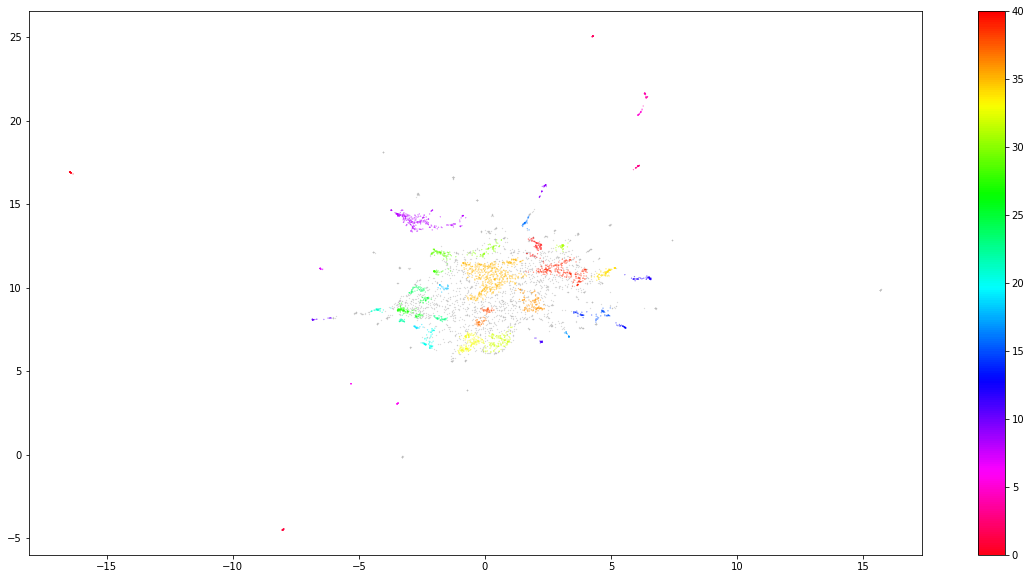

In [15]:
# To visualize the resulting clusters we can further reduce the dimensionality to 2 and visualize the outliers as grey points
import matplotlib.pyplot as plt

# Prepare data
umap_data = umap_embeddings
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.05, cmap='hsv_r')
plt.colorbar()

Step 4: Deriving topics
Finally, the topics can be extracted from the model. This Top2Vec models employs a variation of the well-known TF-IDF method to find out what makes one topic different from another (Grootendorst, 2020). It views each tweet within a cluster as a separate cluster and computes the TF-IDF score for each word within the tweet (or cluster), which then allows us to find the most important words within this tweet (or cluster). Then taking the top 10 most important words in each one of these tweets (or clusters) would then form a good representation of the actual cluster, i.e., the topic. Deriving the top 10 words per topic based on their TF-IDF scores then helps us giving the topic a name. 


In [16]:
# Create the needed data frame and features

docs_df = pd.DataFrame(list_top2vec, columns=["Doc"])
docs_df['Topic'] = cluster.labels_
docs_df['Doc_ID'] = range(len(docs_df))
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

# do calculations
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count
  
tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(data))

# In order to create a topic representation, we take the top 10 words per topic based on their TF-IDF scores. 
# The higher the score, the more representative it should be of its topic as the score is a proxy of information density.

def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=10):
    words = count.get_feature_names()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .Doc
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "Doc": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

# Create new variables by putting the needed input in the previously defined functions
top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=10)
topic_sizes = extract_topic_sizes(docs_df); topic_sizes.head(10)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Topic,Size
0,-1,1874
36,35,505
9,8,277
40,39,229
34,33,144
33,32,135
37,36,129
35,34,81
30,29,76
28,27,75


In [17]:
print(len(topic_sizes))

42


/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Below the top 8 topics are printed with their top 10 key words and their weights

In [20]:
print("Top words for topic 35: " ,top_n_words[35][:10])
print("Top words for topic 8: " ,top_n_words[8][:10])
print("Top words for topic 39: " ,top_n_words[39][:10])
print("Top words for topic 33: " ,top_n_words[33][:10])
print("Top words for topic 32: " ,top_n_words[32][:10])
print("Top words for topic 36: " ,top_n_words[36][:10])
print("Top words for topic 34: " ,top_n_words[34][:10])
print("Top words for topic 29: " ,top_n_words[29][:10])


Top words for topic 35:  [('death', 0.041143505586888465), ('collapse', 0.04073365625730158), ('like', 0.03884105333906134), ('wa', 0.034363440457253855), ('closed', 0.02788319109194826), ('ha', 0.0232689018404457), ('bridge', 0.021570748885873032), ('palestinian', 0.021470811120327636), ('fatality', 0.021237379202028336), ('dead', 0.02097117536492618)]
Top words for topic 8:  [('hiroshima', 0.20484760560477694), ('nuclear', 0.16340398674981205), ('atomic', 0.11691837961353291), ('japan', 0.10991282667864698), ('bombing', 0.0955196530723299), ('iran', 0.07343463761651077), ('anniversary', 0.07007154355124022), ('mark', 0.06424790322454269), ('bomb', 0.057704777705110406), ('nagasaki', 0.05546313647843926)]
Top words for topic 39:  [('mass', 0.10807277102609378), ('attack', 0.0891833669132357), ('police', 0.07534105244084262), ('murder', 0.06897097845693109), ('hostage', 0.06484366261565627), ('militant', 0.06053713211878946), ('murderer', 0.059423016234988274), ('terrorist', 0.05942222

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
